In [35]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers, models
from tensorflow.data import AUTOTUNE
from sklearn.utils import compute_class_weight
from keras.src.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping
from keras.src.optimizers.adamw import AdamW
import os
import matplotlib.pyplot as plt
import keras_tuner as kt
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
ruta_dataset = '../resources/data_med'
clases = sorted(os.listdir(ruta_dataset))
print(f"Clases detectadas ({len(clases)}): {clases}\n")
conteo = {}
for clase in clases:
    ruta_clase = os.path.join(ruta_dataset, clase)
    if os.path.isdir(ruta_clase):
        cantidad = len([
            f for f in os.listdir(ruta_clase)
            if os.path.isfile(os.path.join(ruta_clase, f))
        ])
        conteo[clase] = cantidad

for clase, cantidad in conteo.items():
    print(f"Clase '{clase}': {cantidad} imágenes")

Clases detectadas (4): ['glioma', 'healthy', 'meningioma', 'pituitary']

Clase 'glioma': 1621 imágenes
Clase 'healthy': 2000 imágenes
Clase 'meningioma': 1645 imágenes
Clase 'pituitary': 1757 imágenes


In [4]:
batch_size = 32
img_height = 224
img_width = 224
validation_split = 0.2
seed = 123

In [5]:
train_data_set = image_dataset_from_directory(
    ruta_dataset,
    validation_split = validation_split,
    subset = "training",
    seed = seed,
    image_size = (img_height, img_width),
    batch_size = batch_size,
)

test_data_set = image_dataset_from_directory(
    ruta_dataset,
    validation_split = validation_split,
    subset = "validation",
    seed = seed,
    image_size = (img_height, img_width),
    batch_size = batch_size,
)


Found 7023 files belonging to 4 classes.
Using 5619 files for training.
Found 7023 files belonging to 4 classes.
Using 1404 files for validation.


In [6]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2)
])

normalization_layer = layers.Rescaling(1./255)


In [7]:
train_data_set = train_data_set.map(lambda x, y: (normalization_layer(data_augmentation(x, training=True)), y), num_parallel_calls=AUTOTUNE)

test_data_set = test_data_set.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls = AUTOTUNE)

train_data_set = train_data_set.prefetch(buffer_size = AUTOTUNE)
test_data_set = test_data_set.prefetch(buffer_size = AUTOTUNE)

In [8]:
#Calcular class_weight
y_train = np.concatenate([y.numpy() for _, y in train_data_set])
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(clases)),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))
print(f"Pesos de la clase: {class_weights_dict}")

Pesos de la clase: {0: 1.0674392097264438, 1: 0.8919047619047619, 2: 1.0658194233687406, 3: 0.9962765957446809}


In [9]:
def build_model(hp):
    base_model = MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(img_height, img_width, 3)
    )

    unfreeze_layers = hp.Int('unfreeze_layers', min_value=20, max_value=100, step=20)
    for layer in base_model.layers[:-unfreeze_layers]:
        layer.trainable = False
    for layer in base_model.layers[-unfreeze_layers:]:
        layer.trainable = True

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(hp.Float('dropout', 0.2, 0.5, step=0.1)),
        layers.Dense(len(clases), activation='softmax')
    ])

    learning_rate = hp.Choice('learning_rate', [1e-5, 1e-4, 5e-5])
    weight_decay = hp.Choice('weight_decay', [1e-4, 1e-5])

    model.compile(
        optimizer=AdamW(learning_rate=learning_rate, weight_decay=weight_decay),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [10]:
print("Iniciando búsqueda de hiperparámetros...")
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=7,
    executions_per_trial=1,
    directory='kerastuner_dir',
    project_name='efficientnet_brain_mri'
)

tuner.search(
    train_data_set,
    validation_data=test_data_set,
    epochs=20,
    class_weight=class_weights_dict,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)   

Trial 7 Complete [00h 24m 35s]
val_accuracy: 0.9814814925193787

Best val_accuracy So Far: 0.9814814925193787
Total elapsed time: 02h 31m 18s


In [11]:
best_model = tuner.get_best_models(num_models=1)[0]
loss, accuracy = best_model.evaluate(test_data_set)
print(f"Mejor modelo - Loss: {loss}, Accuracy: {accuracy:.4f}")


44/44 [==============================] - 10s 204ms/step - loss: 0.0580 - accuracy: 0.9815
Mejor modelo - Loss: 0.05801627039909363, Accuracy: 0.9815


In [12]:
history = best_model.fit(
    train_data_set,
    validation_data=test_data_set,
    epochs=20,
    class_weight=class_weights_dict,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

Epoch 1/20
176/176 [==============================] - 80s 424ms/step - loss: 0.0296 - accuracy: 0.9902 - val_loss: 0.0891 - val_accuracy: 0.9715
Epoch 2/20
176/176 [==============================] - 73s 410ms/step - loss: 0.0340 - accuracy: 0.9881 - val_loss: 0.0585 - val_accuracy: 0.9808
Epoch 3/20
176/176 [==============================] - 72s 406ms/step - loss: 0.0221 - accuracy: 0.9939 - val_loss: 0.0516 - val_accuracy: 0.9850
Epoch 4/20
176/176 [==============================] - 72s 405ms/step - loss: 0.0209 - accuracy: 0.9927 - val_loss: 0.0740 - val_accuracy: 0.9786
Epoch 5/20
176/176 [==============================] - 72s 407ms/step - loss: 0.0254 - accuracy: 0.9902 - val_loss: 0.0788 - val_accuracy: 0.9779
Epoch 6/20
176/176 [==============================] - 72s 405ms/step - loss: 0.0220 - accuracy: 0.9932 - val_loss: 0.0834 - val_accuracy: 0.9793
Epoch 7/20
176/176 [==============================] - 72s 406ms/step - loss: 0.0236 - accuracy: 0.9915 - val_loss: 0.0691 - val_ac

In [13]:
loss, accuracy = best_model.evaluate(test_data_set)
print(f"Evaluación final - Loss: {loss}, Accuracy: {accuracy:.4f}")

44/44 [==============================] - 9s 200ms/step - loss: 0.0516 - accuracy: 0.9850
Evaluación final - Loss: 0.05164135619997978, Accuracy: 0.9850


   Trial  Val_Accuracy  Accuracy  unfreeze_layers  dropout  learning_rate  \
6      6      0.981481  0.991102               80      0.3        0.00010   
3      3      0.980057  0.993237              100      0.2        0.00010   
5      5      0.972934  0.985763               40      0.3        0.00010   
1      1      0.967236  0.989322               80      0.3        0.00005   
4      4      0.945869  0.978466               20      0.2        0.00005   
2      2      0.940883  0.976864               40      0.4        0.00005   
0      0      0.888889  0.932728               20      0.3        0.00001   

   weight_decay  
6       0.00001  
3       0.00001  
5       0.00010  
1       0.00010  
4       0.00001  
2       0.00010  
0       0.00010  


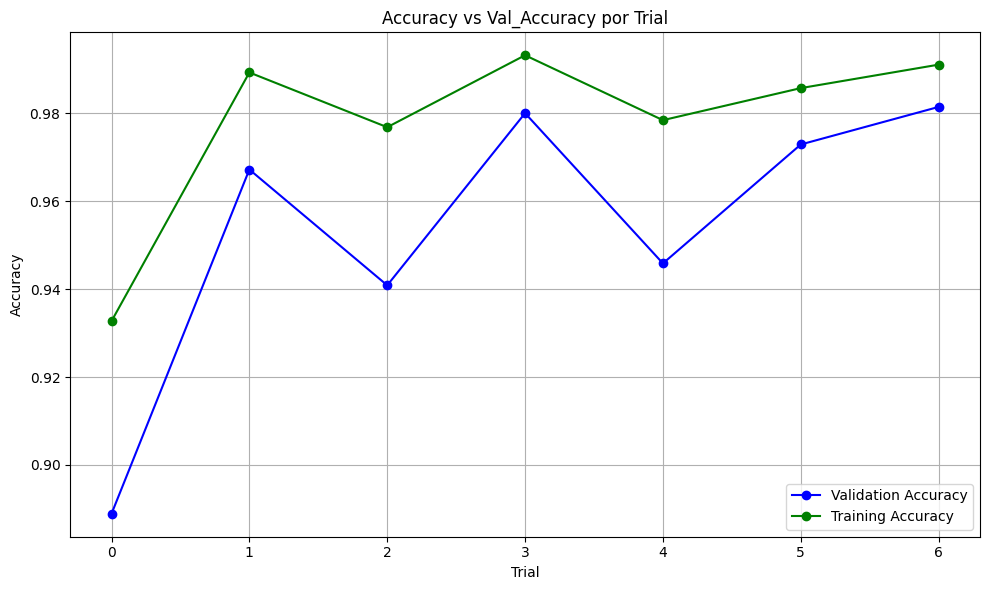

In [45]:
trials = tuner.oracle.trials.values()

results = []
for i, trial in enumerate(trials):
    result = {
        'Trial': i,
        'Val_Accuracy': trial.metrics.get_best_value('val_accuracy'),
        'Accuracy': trial.metrics.get_best_value('accuracy'),
        **trial.hyperparameters.values 
    }
    results.append(result)

df = pd.DataFrame(results)

df_sorted = df.sort_values(by='Val_Accuracy', ascending=False)
print(df_sorted)

plt.figure(figsize=(10, 6))
plt.plot(df['Trial'], df['Val_Accuracy'], marker='o', label='Validation Accuracy', color='blue')
plt.plot(df['Trial'], df['Accuracy'], marker='o', label='Training Accuracy', color='green')
plt.title('Accuracy vs Val_Accuracy por Trial')
plt.xlabel('Trial')
plt.ylabel('Accuracy')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 195ms/step


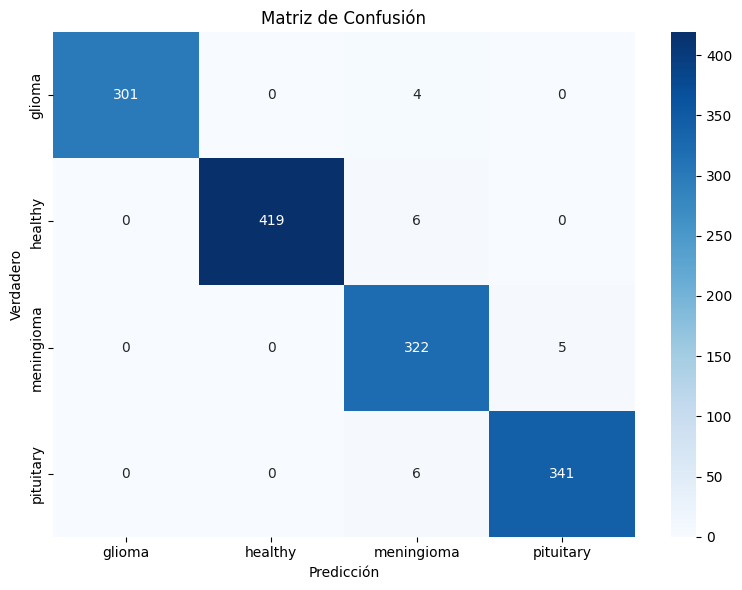

Informe de Clasificación:

              precision    recall  f1-score   support

      glioma       1.00      0.99      0.99       305
     healthy       1.00      0.99      0.99       425
  meningioma       0.95      0.98      0.97       327
   pituitary       0.99      0.98      0.98       347

    accuracy                           0.99      1404
   macro avg       0.98      0.99      0.98      1404
weighted avg       0.99      0.99      0.99      1404



In [43]:
#matriz de confusion
y_true = []
y_pred = []

for images, labels in test_data_set:
    preds = best_model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=clases, yticklabels=clases)
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión')
plt.tight_layout()
plt.show()

# Informe de clasificación
print("Informe de Clasificación:\n")
print(classification_report(y_true, y_pred, target_names=clases))

1/1 [==============================] - 0s 181ms/step


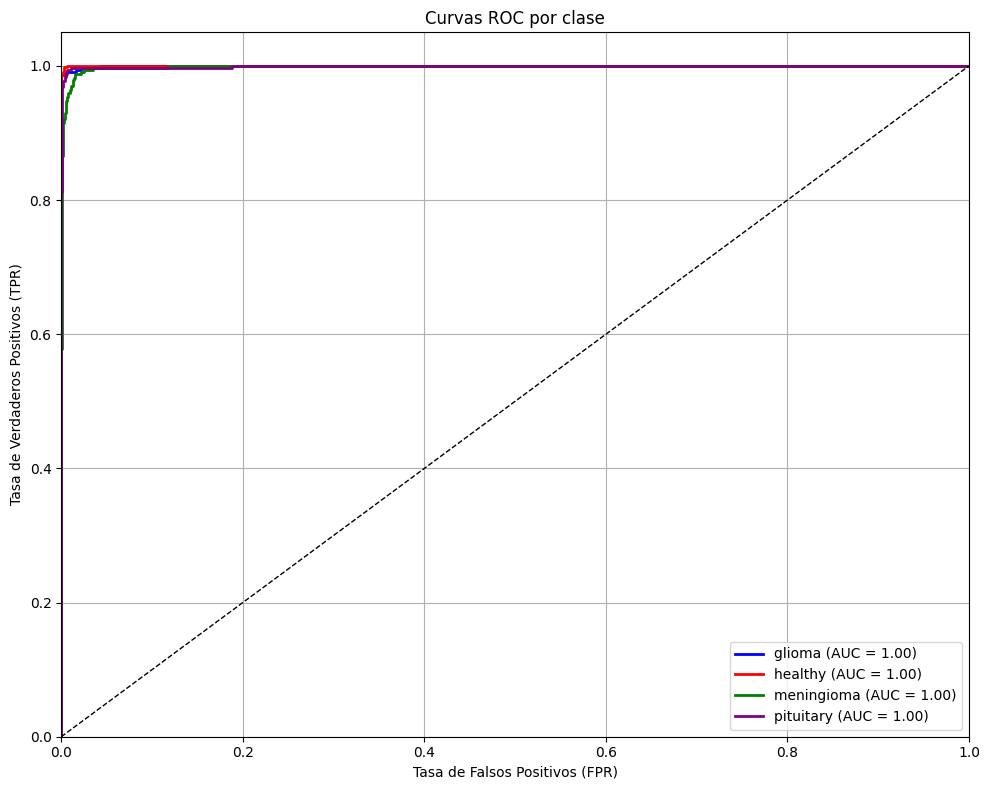

In [38]:
#curva ROC
y_true = []
y_pred = []

for images, labels in test_data_set:
    preds = best_model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Binarizar etiquetas (One-hot) para ROC multiclase
y_true_bin = label_binarize(y_true, classes=range(len(clases)))

# Calcular ROC y AUC por clase
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(clases)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Dibujar la curva ROC para cada clase
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'purple']
for i, color in zip(range(len(clases)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{clases[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC por clase')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()